In [1]:
from google.colab import drive # access data in Google Drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/My Drive/medical imaging/Project

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1MDKwzbdPctpPasZeQI_lmHv5pEuJjJ5b/medical imaging/Project


In [2]:
!pip install -r requirements.txt

In [3]:
pip install pydensecrf

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle 
import tensorflow as tf #for TensorBoard
import datetime
import torch
import segmentation_models_pytorch as smp
import sys
import tqdm
from sklearn.model_selection import train_test_split
from torchnet.meter import AverageValueMeter
import tensorflow as tf
from tensorflow import summary

from utils.utils import *
from utils.Data import *
from utils.preprocess_func import *
from utils.train_utils import *
from models.encoders import *

import matplotlib.image as mpimg
from matplotlib.pyplot import imshow

import pydensecrf.densecrf as dcrf

from pydensecrf.utils import compute_unary, create_pairwise_bilateral,\
         create_pairwise_gaussian, softmax_to_unary, unary_from_softmax
from pydensecrf.utils import unary_from_labels


#Loading dataset

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']
./LGG/label/BraTS19_TCIA09_141_1/BraTS19_TCIA09_141_1_95.jpg
2188


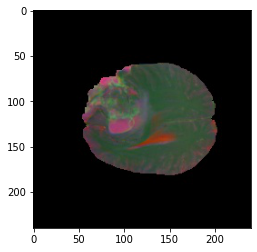

In [5]:
print(sys.path)
#DATA_DIR = '/content/gdrive/My Drive/medical imaging/Project/train_final_solution'
#DATA_DIR = './train_final_solution' old script

DATA_DIR = './3D data'
LGG_DATA_DIR = './LGG'

labeldir = os.path.join(DATA_DIR, 'label')
# load repo with data if it is not exists
with open('label_path2.pkl', 'rb') as f1:
    label_path2 = pickle.load(f1)
with open('img_path2.pkl', 'rb') as f3:
    img_path2 = pickle.load(f3)  
with open('pickle_LGG/label_LGGmorethan5.pkl', 'rb') as f4:
    label_path3 = pickle.load(f4)
with open('pickle_LGG/LGGmorethan5.pkl', 'rb') as f5:
    img_path3 = pickle.load(f5)  
   

for i in range(len(label_path2)):
    path = label_path2[i].split('/')
    label_path2[i] = os.path.join(DATA_DIR, 'label', path[-2], path[-1])
for i in range(len(img_path2)):
    path = img_path2[i].split('/')
    img_path2[i] = os.path.join(DATA_DIR, path[-2], path[-1]) 
for i in range(len(label_path3)):
    path = label_path3[i].split('/')
    label_path3[i] = os.path.join(LGG_DATA_DIR, 'label', path[-2], path[-1])
for i in range(len(img_path3)):
    path = img_path3[i].split('/')
    img_path3[i] = os.path.join(LGG_DATA_DIR, path[-2], path[-1]) 
 
img_path = sorted(img_path2)
label_path = sorted(label_path2)
img_path_lgg = sorted(img_path3)
label_path_lgg = sorted(label_path3)

#img_hgg_lgg = img_path + img_path_lgg
#label_hgg_lgg = label_path + label_path_lgg
# we have 1045 lgg and 2188 hgg (only those with >5% tumor, total was 11780 and 40155 respectively)
#trainval_img, test_img, trainval_label, test_label = train_test_split(img_hgg_lgg, label_hgg_lgg, test_size=0.1, random_state=42) #10% test set 

# (we have 40155 jpgs of HGG and 11780 LGG, but only 2188 and 1045 respectively with more than 5% tumor, all the rest are less then 5%)
trainval_img = img_path[0:1968]+img_path_lgg[0:940] # 90% Train+Val set 
trainval_label = label_path[0:1968]+label_path_lgg[0:940]

#valid_img = img_path[1750:1968] # 10% Validation set - 218 images
#valid_label = label_path[1750:1968]

test_img = img_path[1968::]+img_path_lgg[940::]   # 10% Test set - 219+105 images
test_label = label_path[1968::]+label_path_lgg[940::] #splitting with list and not randomly to avoid data leakage to test

train_img, val_img, train_label, val_label = train_test_split(trainval_img, trainval_label, test_size=0.125, random_state=36) #10% val set, 80% train set

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow

print(train_label[1])

img = mpimg.imread(train_img[1])
imshow(img)

hasTestSet = False # use test or validation data 
print(len(label_path2)) #length of dataset

choose model path

In [6]:
#Encoder settings
ENCODER = 'se_resnext101_32x4d'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'
CLASSES = ['core']#['complete','core','unlabelled']
ACTIVATION = 'sigmoid'  
channels = 3
Encoder_depth=4
Upsamplingpsp = 16 #for pspnet, usually 2^depth to ensure equal in/out image sizes
Upsamplingdeeplab = 8
Decoder_channels = [256, 128, 64, 32]
Download_model = False  #True = Download pretrained weights from scratch; False = Take the already downloaded network from the path
decoderModel = 'Linknet' #Unet\PSPnet\DeepLab\Linknet

In [7]:
best_path = "Checkpoints/LGGHGG_decoder_Linknet_encoder_resnext101_32x4d_batchsize_20CrossVal__Checkpoint86.pth"
best_model = torch.load(best_path)
preprocessing_fn = get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS) 

create test set

In [8]:
test_dataset = Dataset(
    test_img, 
    test_label,
    augmentation=get_validation_augmentation(), #only padding 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_dataset = Dataset(
    train_img, 
    train_label, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)


In [9]:
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow

from skimage.color import gray2rgb

label = mpimg.imread(label_path[1])

print(label.shape)

(240, 240)


In [10]:
pip install scikit-image

In [11]:
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    #annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    annotated_label = mask_img[:,:,0]
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.9, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))


In [18]:
def test_crf(dataset,DEVICE, best_model,N=0):
    "Evaluation random images for example and visualizing them"
    "N = the number of the example in the test dataset (0-218)"
    for i in range(1):
        n = N
        image_vis = dataset[n][0].squeeze().transpose(1,2,0)
        image, gt_mask, impath = dataset[n]
        gt_mask=gt_mask.transpose(1,2,0)
        #label = (gt_mask >= 25).astype('uint8')

        image_crf = image.transpose(1,2,0)

        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        pr_mask = best_model.predict(x_tensor)
        pr_mask = pr_mask.cpu().squeeze(dim=1).numpy().round().transpose(1,2,0) # started with (1,1,256,256) tensor, ends with (256,256,1) numpy
        
        pr_mask_crf = crf(image_crf,pr_mask)
        pr_mask_crf = pr_mask_crf.astype('uint8')
        pr_mask_crf = np.expand_dims(pr_mask_crf,axis=-1)
        gt_mask = gt_mask.astype('uint8')
        pr_mask = pr_mask.astype('uint8')

        print(np.amax(pr_mask_crf))
        print(np.amax(gt_mask))

        print(gt_mask.shape)
        print(pr_mask_crf.shape)
        #gt_mask = np.squeeze(gt_mask)

        IOU_mask = iou_numpy(pr_mask,gt_mask)
        IOU_crf = iou_numpy(pr_mask_crf,gt_mask)
        print('iou pred: '+ str(IOU_mask))
        print('iou crf: '+ str(IOU_crf))

        Dice_mask = single_dice_coef(pr_mask,gt_mask)
        Dice_crf = single_dice_coef(pr_mask_crf,gt_mask)

        print('dice score pred: '+ str(Dice_mask))
        print('dice crf: '+ str(Dice_crf))

        visualize(
            image=image.squeeze().transpose(1,2,0),
            ground_truth_mask=gt_mask.squeeze(),
            predicted_mask=pr_mask.squeeze(),
            after_CRF=np.squeeze(pr_mask_crf) 

        )
        #plt.imshow(np.squeeze(pr_mask_crf))

IOU score

In [19]:
# Numpy version
# Well, it's the same function, so I'm going to omit the comments

def iou_numpy(outputs: np.array, labels: np.array):
   
   intersection = np.logical_and(outputs, labels)
   
   union = np.logical_or(outputs, labels)
   
   iou_score = np.sum(intersection) / np.sum(union)
    
   return iou_score
'''
def DiceLoss(targets, inputs, smooth=1e-6):

    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    intersection = K.sum(K.dot(targets, inputs))
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice
'''
def single_dice_coef(y_pred_bin, y_true):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin) + 1e-6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./3D data/BraTS19_TMC_06290_1/BraTS19_TMC_06290_1_84.jpg


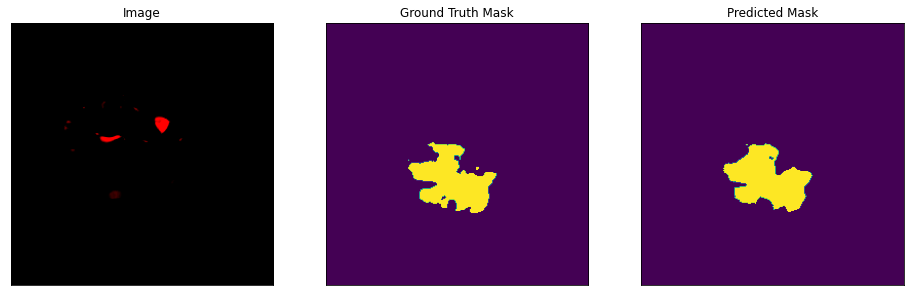

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
1
(256, 256, 1)
(256, 256, 1)
iou pred: 0.8404193360512522
iou crf: 0.8389066589124745
dice score pred: 0.9132911390959982
dice crf: 0.9123972168070212


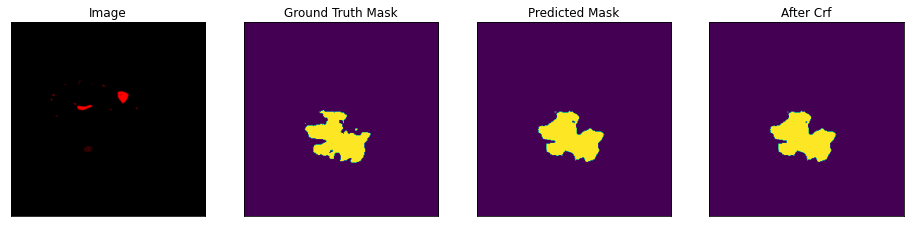

In [20]:
Test_Specipic(test_dataset,DEVICE,best_model,160)
test_crf(test_dataset,DEVICE,best_model,160)

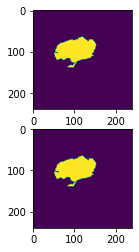

In [ ]:
img = mpimg.imread(img_path[50])
label = mpimg.imread(label_path[50])
label = (label >= 25).astype('uint8')
#print(label.shape)
outputs = crf(img, label)
plt.subplot(2,1,1)
plt.imshow(outputs)
plt.subplot(2,1,2)
plt.imshow(label)
#imshow(outputs)